# **Código para o módulo de Machine Learning 2**
---
### **Aprendizado não supervisionado**


1.   **TRATAMENTO DOS DADOS** - Neste código consta um processo de tratamento de variáveis robusto. Foi realizado tratamento de: outliers, variáveis categóricas e avaliadas as correlações entre variáveis.

2.   **MODELO DE CLUSTERIZAÇÃO** - O problema enfrentado nesse dataset era segmentar clientes de um banco. A partir disso, desenvolvemos modelos de clusterização como K-Means e DBSCAN.


## Bibliotecas

In [ ]:
#!pip install factor-analyzer

# Manipulação de dados
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processamento
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer import calculate_kmo
from scipy.stats import bartlett

# Modelos
from sklearn.cluster import KMeans

# Tirar avisos
import warnings
warnings.filterwarnings("ignore")

## Importando os dados

In [ ]:
dt = pd.read_csv('Customer-Churn-Records.csv',delimiter=',')
dt

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339


## Coleta de informações sobre o Dataset

In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

## Funções de pré-tratamento

In [ ]:
def varre_linha(data, lnh):
  dt_aux = np.array(data.iloc[lnh:lnh+1])
  ln, cl = dt_aux.shape
  x=0
  for c in range(cl):
    if dt_aux[0][c]>3:
      x=1
    break
  return x

def varrendo_col_obj(data):
  print("Cortando caminho e trabalho chato.\n")
  cont = 0
  obj = data.select_dtypes(include=object)
  for cl in obj.columns:
    cont = cont+1
    print(f'Value_counts da {cont}º Variável categórica:\n')
    print(f'{data[cl].value_counts()}\n')

def varre_linha(data, lnh):
  dt_aux = np.array(data.iloc[lnh:lnh+1])
  ln, cl = dt_aux.shape
  x=0
  for c in range(cl):
      if dt_aux[0][c]>3:
        x=1
        break
  return x

def idt_out(data):
  colunas = data.select_dtypes(include=object).columns
  x = data.drop(colunas, axis=1)
  scaler = StandardScaler()
  dt_norm = pd.DataFrame(scaler.fit_transform(x)).reset_index()
  dt_aux = dt_norm.drop('index', axis=1)
  outliers = []
  ln, cl = dt_aux.shape

  for lnh in range(ln):
    if varre_linha(dt_aux,lnh)==1:
      outliers.append(dt_norm['index'][lnh])
  return outliers

def remove_out(data):
  obj = data.select_dtypes(include=object)
  data_gd = pd.get_dummies(data, columns=obj.columns).astype(float)
  out = idt_out(data)
  data_clear = data_gd.drop(out,axis=0)
  return data_clear

data_clear = pd.DataFrame(remove_out(dt))

## PCA

In [ ]:
def viabilidade_do_pca(data):

  # Teste de Esfericidade de Bartlett
  chi_square_value, p_value = bartlett(*[data[col] for col in data.columns])
  print(f'Chi-Square: {chi_square_value}')
  print(f'P-Value: {p_value}')

  if p_value < 0.05:
      verificador = 'A matriz de correlação não é uma matriz identidade, PCA é adequado'
  else:
      verificador = 'A matriz de correlação é uma matriz identidade, PCA não é adequado.'

  return verificador

viabilidade_do_pca(data_clear)

'A matriz de correlação não é uma matriz identidade, PCA é adequado'

In [ ]:
pca = PCA()
pca.fit(data_clear)
pd.DataFrame(pca.explained_variance_ratio_)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

print("Variância explicada acumulada para os 20 primeiros componentes:")
print(cumulative_explained_variance[:3])

Variância explicada acumulada para os 20 primeiros componentes:
[0.41799414 0.73282255 0.99932093]


In [ ]:
pca = PCA(n_components = 3)
pca.fit(data_clear)
scaler = StandardScaler()
dt_norm = pd.DataFrame(scaler.fit_transform(pca.transform(data_clear)))
df = pd.DataFrame(dt_norm)

## k-means

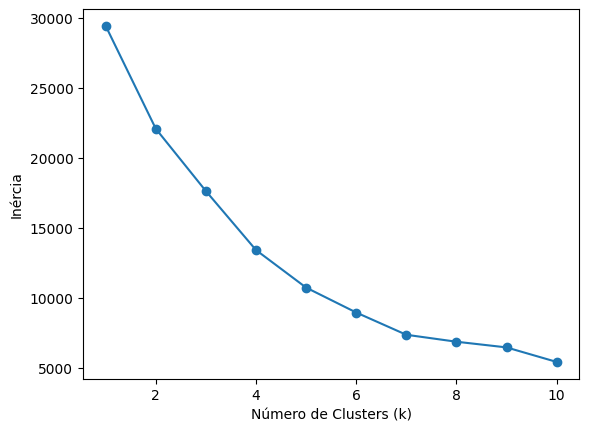

In [ ]:
inertias = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaler.fit_transform(pca.transform(data_clear)))
    inertias.append(kmeans.inertia_)

plt.plot(k_values, inertias, '-o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.show()

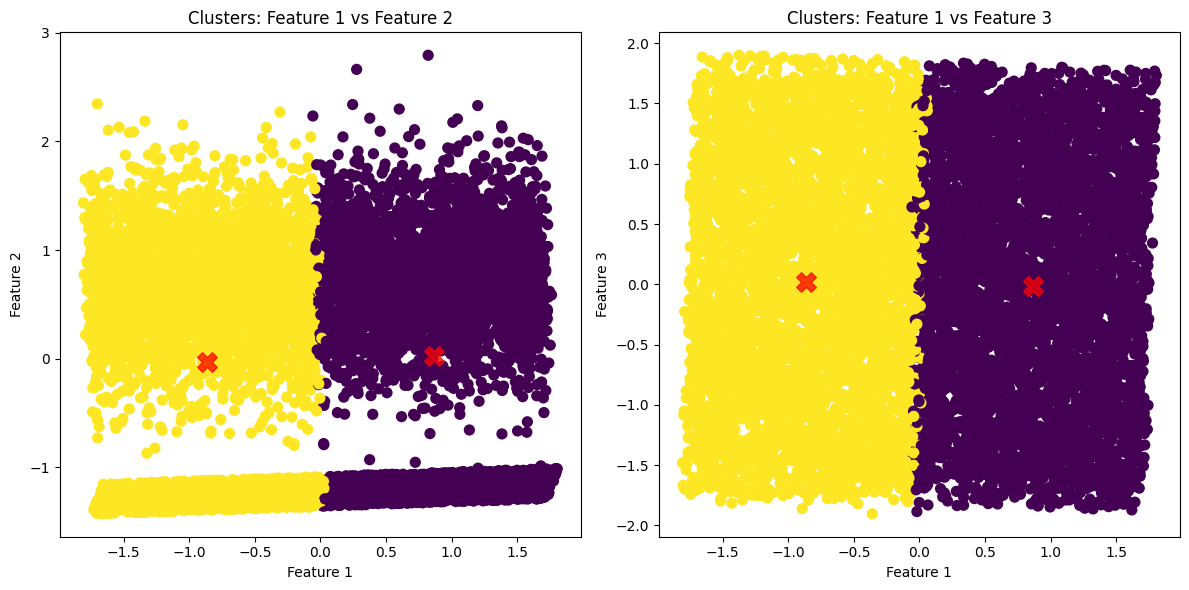

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaler.fit_transform(pca.transform(data_clear)))
y_kmeans = kmeans.predict(scaler.fit_transform(pca.transform(data_clear)))
centers = kmeans.cluster_centers_

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters: Feature 1 vs Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(df.iloc[:, 0], df.iloc[:, 2], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 2], c='red', s=200, alpha=0.75, marker='X')
plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title('Clusters: Feature 1 vs Feature 3')

plt.tight_layout()
plt.show()

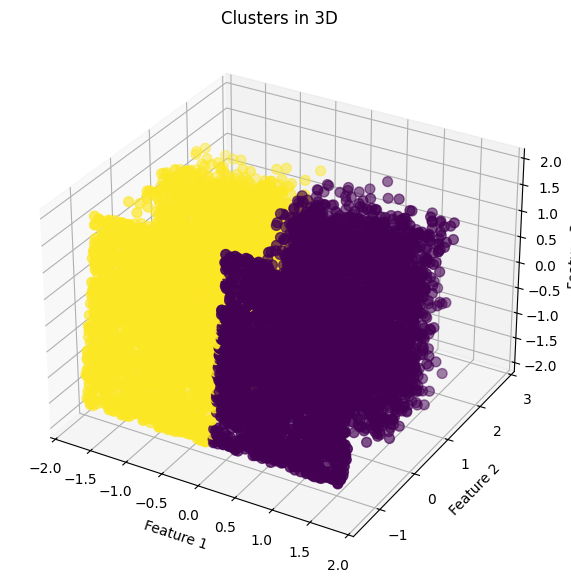

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2], c=y_kmeans, s=50, cmap='viridis')
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=200, alpha=0.75, marker='X')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('Clusters in 3D')

plt.show()

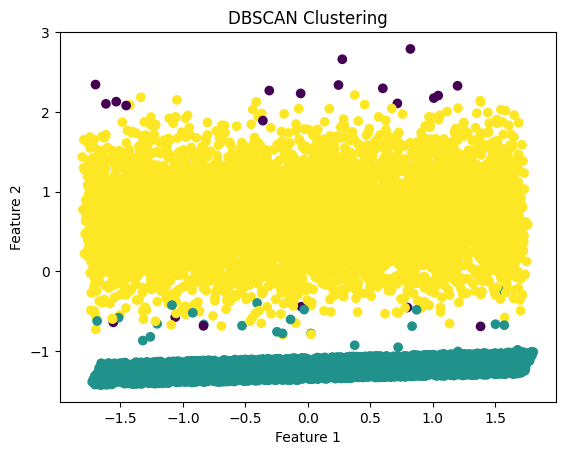

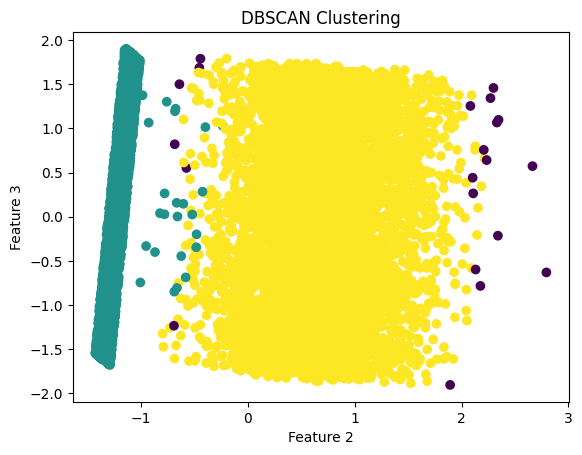

In [ ]:
from sklearn.cluster import DBSCAN
pca = PCA(n_components = 3)
pca.fit(data_clear)
scaler = StandardScaler()
dt_norm = pd.DataFrame(scaler.fit_transform(pca.transform(data_clear)))
df = pd.DataFrame(dt_norm)

dbscan = DBSCAN(eps=0.5, min_samples=30)

dbscan.fit(df)

labels = dbscan.labels_

df['cluster'] = labels

plt.scatter(df[0], df[1], c=labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering')
plt.show()

plt.scatter(df[1], df[2], c=labels, cmap='viridis')
plt.xlabel('Feature 2')
plt.ylabel('Feature 3')
plt.title('DBSCAN Clustering')
plt.show()

## Conclusão

Após implementar ambos os modelos, DBScan e KNN, concluímos que caso desejemos separar em 3 clusters: Churn, Não churn e Churn que depois retorna ao serviço, o DBSCAN pode ser mais adequado, contudo, Para separar em 2 clusters: Churn, Não churn o KNN pode ser mais adequado.